# Loading libraries

In [ ]:
import os
import tqdm
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score
import matplotlib.pyplot as plt
from src.models.resnet import ResNet18
from src.libs.data_loading import create_dataset_classification
import xml.etree.ElementTree as ET
import cv2
from typing import List, Tuple
import warnings
warnings.filterwarnings("ignore")

2024-11-30 01:14:23.135016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732940063.291089  123450 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732940063.325842  123450 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 01:14:23.660035: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_path = "ssl_images/data"
data_dir = os.path.join(data_path, "processed", "pascal_voc")
metadata_dir = os.path.join(data_path, "pascal_voc", "ImageSets", "Main")

model = ResNet18((224, 224, 3), mode="classification", num_classes=1)
model.load_weights('classification_ckpt/classification_ckpt_CE_person/segmentation_model_epoch_007.weights.h5')

2024-11-28 23:10:53.116666: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-28 23:10:53.117081: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Baseline classifier

## Evaluate on validation dataset

In [3]:
val_dataset = create_dataset_classification(
    data_dir,
    split_list_file=os.path.join(metadata_dir, "val.txt"),
    batch_size=32,
    single_channel=False,
    classes=['person']
)

In [4]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.1),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(multi_label=True, name="auc_roc"),
        tf.keras.metrics.AUC(curve="PR", name="average_precision"),
    ],
)

In [5]:
model.evaluate(val_dataset)

182/182 [==============================] - 80s 423ms/step - loss: 0.7056 - binary_accuracy: 0.6636 - precision: 0.5717 - recall: 0.4879 - auc_roc: 0.6901 - average_precision: 0.5922


[0.7056241631507874,
 0.6635754704475403,
 0.5716535449028015,
 0.4879032373428345,
 0.6901428699493408,
 0.5921595096588135]

## Threshold for maximum F1

In [6]:
scores = []
samples = []
labels = []

for batch_images, batch_labels in val_dataset:
    predictions = model.predict(batch_images, verbose=0)
    pred_scores = np.squeeze(predictions)
    
    scores.extend(pred_scores)
    samples.extend(batch_images)
    labels.extend(batch_labels)

scores = np.array(scores)
samples = np.array(samples)
labels = np.array(labels)

In [9]:
precision, recall, thresholds = precision_recall_curve(labels, scores)
f1_scores = 2 * (precision * recall) / (precision + recall)

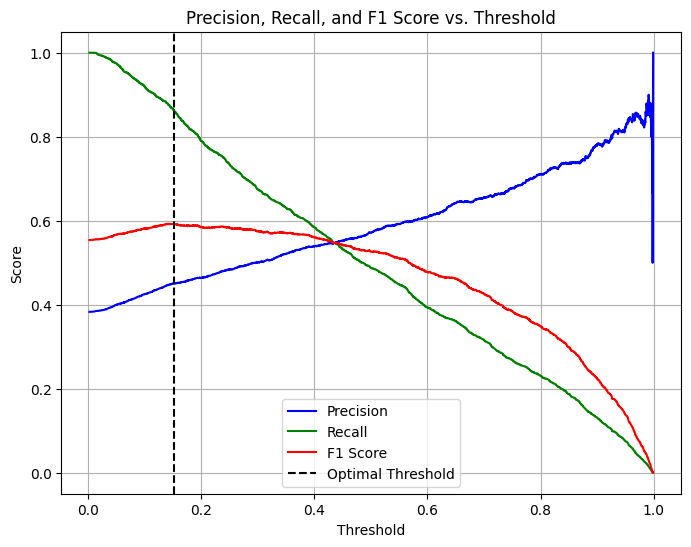

Best Threshold: 0.15
Max F1 Score: 0.59
Precision at best threshold: 0.45
Recall at best threshold: 0.86
Binary accuracy: 0.55


In [10]:
best_f1_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_f1_idx]

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="green")
plt.plot(thresholds, f1_scores[:-1], label="F1 Score", color="red")
plt.axvline(x=best_threshold, color="black", linestyle="--", label="Optimal Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 Score vs. Threshold")
plt.legend(loc="best")
plt.grid()
plt.show()

y_pred_optimal = (scores >= best_threshold).astype(int)

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Max F1 Score: {f1_scores[best_f1_idx]:.2f}")
print(f"Precision at best threshold: {precision[best_f1_idx]:.2f}")
print(f"Recall at best threshold: {recall[best_f1_idx]:.2f}")
print(f"Binary accuracy: {accuracy_score(labels, y_pred_optimal):.2f}")

## T-SNE visualization

In [11]:
embedding_model = tf.keras.models.Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [12]:
all_y = []
all_embeddings = []
for batch in tqdm.tqdm(val_dataset):
    x, y = batch
    pred = embedding_model.predict(x, verbose=0)
    all_y.extend(y)
    all_embeddings.extend(pred)

all_y = np.array(all_y)
all_embeddings = np.array(all_embeddings)

100%|█████████████████████████████████████████████████████████████████████████████████| 182/182 [01:46<00:00,  1.70it/s]


In [13]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=50)
features = tsne.fit_transform(all_embeddings)

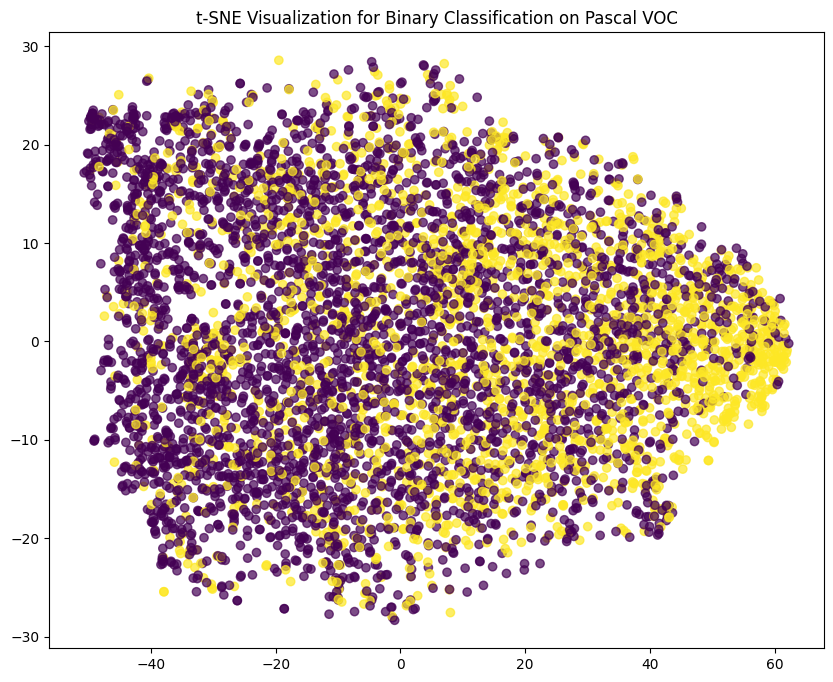

In [14]:
# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features[:, 0], features[:, 1], c=all_y, cmap='viridis', alpha=0.7)
plt.title("t-SNE Visualization for Binary Classification on Pascal VOC")
plt.show()

## Visualize samples by confidence

In [15]:
# Sort indices by score
sorted_indices = np.argsort(scores)

num_samples = 5  # Number of samples to visualize

highest_score_indices = sorted_indices[-num_samples:]
lowest_score_indices = sorted_indices[:num_samples]

# Intermediate confidence samples (~50%)
threshold_low = 0.48
threshold_high = 0.52
intermediate_score_indices = np.where((scores >= threshold_low) & (scores <= threshold_high))[0]
intermediate_score_indices = intermediate_score_indices[:num_samples]

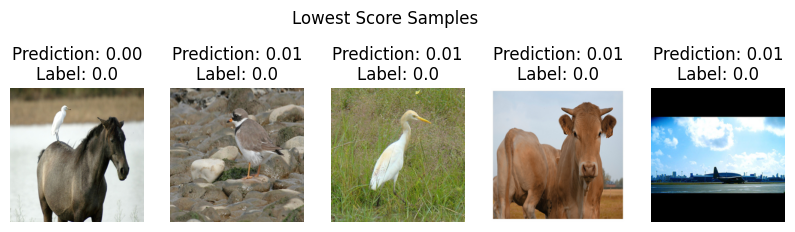

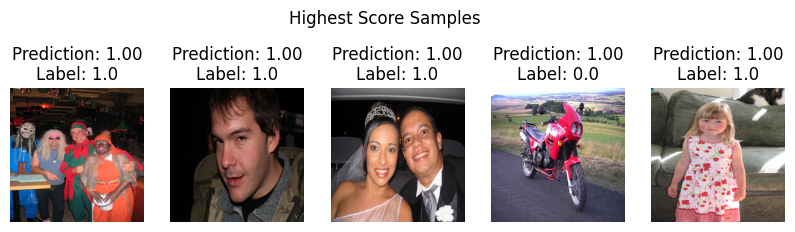

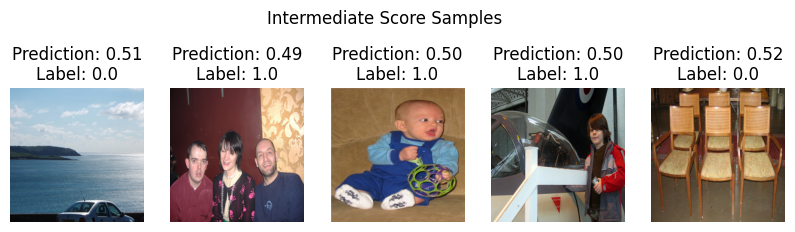

In [16]:
def visualize_samples(indices, title):
    plt.figure(figsize=(10, 3))
    for i, idx in enumerate(indices):
        plt.subplot(1, len(indices), i + 1)
        plt.imshow(samples[idx])
        plt.title(f"Prediction: {scores[idx]:.2f}\nLabel: {labels[idx][0]}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()
    
# Visualize lowest score samples
visualize_samples(lowest_score_indices, "Lowest Score Samples")

# Visualize highest score samples
visualize_samples(highest_score_indices, "Highest Score Samples")

# Visualize intermediate score samples
visualize_samples(intermediate_score_indices, "Intermediate Score Samples")

# Classifier using pre-trained colorization and inpainting backbone

## Load data

In [ ]:
metadata_dir = "~/Documents/dev/val.txt"
data_dir = "~/Documents/dev/PascalVOC/VOC2012"

def get_dataset(
        dataset_path: str,
        metadata_dir: str,
        channels: int
        ) -> Tuple[List[tf.Tensor], List[tf.Tensor]]:

    x, y = [], []
    annotations = os.path.join(dataset_path, "Annotations")
    f = open(metadata_dir, "r")
    for img_name in f:
        img_path = os.path.join(dataset_path, "JPEGImages", f"{img_name.strip()}.jpg")
        input_image = cv2.imread(img_path)
        if channels == 3:
            input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
        else:
            input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
        input_image = cv2.resize(input_image, (224, 224))
        input_image = input_image.astype(np.float32) / 255.
        if channels==3:
            input_image = np.expand_dims(input_image, axis=0)
        else:
            input_image = np.expand_dims(input_image, axis=-1)
        
        tree = ET.parse(os.path.join(annotations, f"{img_name.strip()}.xml"))
        root = tree.getroot()
        label = list(set([obj.find("name").text for obj in root.findall("object") if obj.find("name").text == 'person']))
        if len(label) > 0:
            label = 1
        else:
            label = 0
        
        x.append(input_image)    
        y.append(label)
    return x,y
x_1,y_1 = get_dataset(data_dir,metadata_dir,1)
x_3,y_3 = get_dataset(data_dir,metadata_dir,3)

## Load backbone weights

Download the colorization model weights here: https://drive.google.com/file/d/1sXpeVJb6C436LgZZwy_sxCUsC_UOOOtz/view?usp=drive_link 
Download the inpainting model weights here: https://drive.google.com/file/d/1giLKaR6FnhZXNZFcp9OgfNjY2XCwrtOH/view?usp=sharing 

In [ ]:
colorization_weights = "~/Downloads/best_model.h5"
inpainting_weights = "~/Documents/dev/weights-099-0.1612.weights.h5"

## Load fine-tuned classifier weights

Download the colorization pretrained fine-tuned classifier: https://drive.google.com/file/d/1b4sYI-kofN9mec2Z2ZHuLos5Gd4zj5RB/view?usp=sharing

Download the inpainting pretrained fine-tuned classifier: https://drive.google.com/file/d/1iK_81APgopxcNr7OcZQjwCOwwfjyzQbv/view?usp=sharing

In [ ]:
c_classifier_weights = "~/Documents/dev/weights-004-0.4904.weights.h5"
i_classifier_weights = "~/Documents/dev/weights-038-0.3537.weights.h5"

## T-SNE visualization

### Colorization

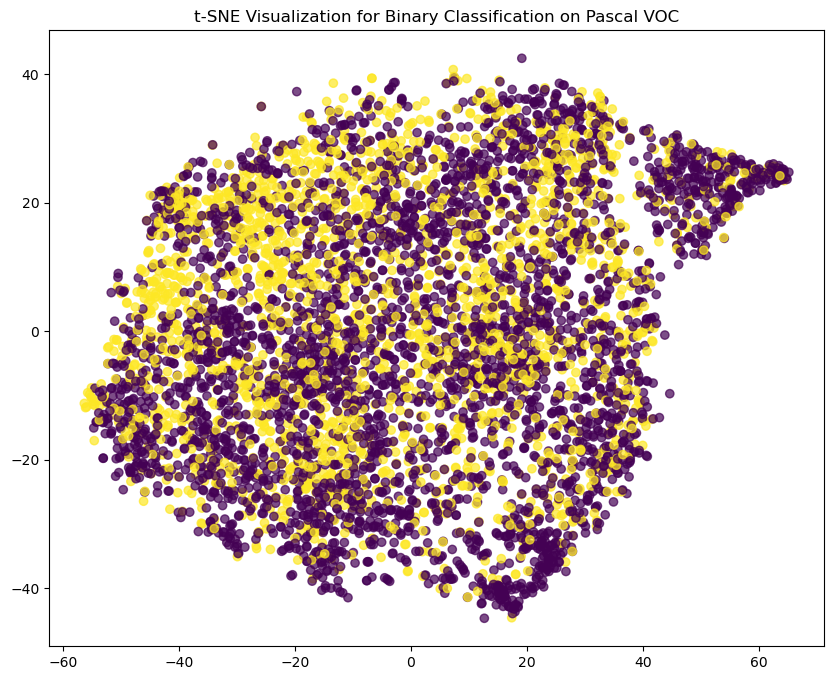

In [15]:
model = ResNet18((224, 224, 1), mode="classification", num_classes=1)
model.load_weights(colorization_weights, skip_mismatch=True, by_name = True)
embedding_model = tf.keras.models.Model(inputs=model.input, outputs=model.layers[-2].output)

y_pred = []
for i in range(len(y_1)):
    y_pred.append(tf.squeeze(embedding_model.predict(x_1[i], verbose = 0)))

y_pred = np.array(y_pred)
tsne = TSNE(n_components=2, perplexity=50)
features = tsne.fit_transform(y_pred)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features[:, 0], features[:, 1], c=y_1, cmap='viridis', alpha=0.7)
plt.title("t-SNE Visualization for Binary Classification on Pascal VOC")
plt.show()

### Inpainting

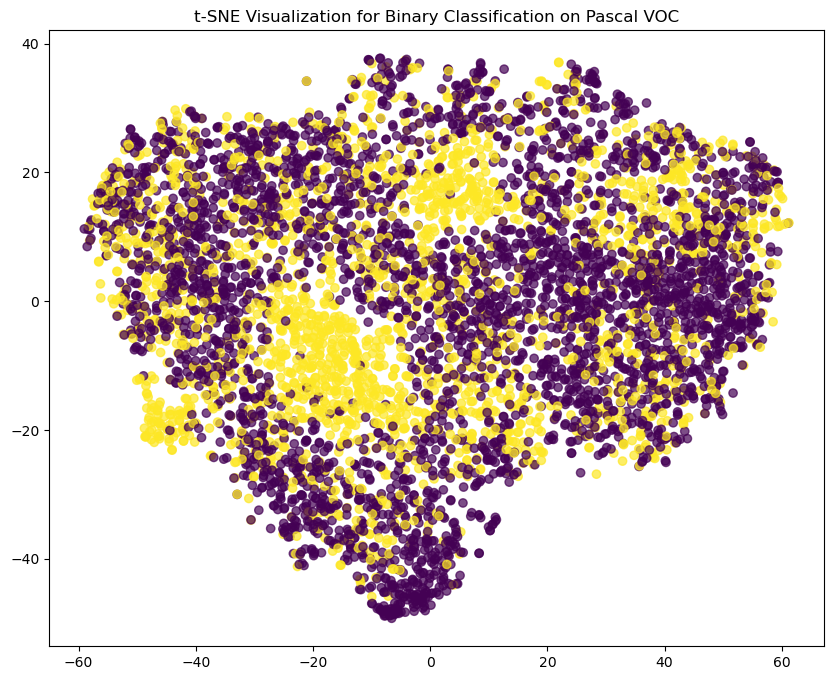

In [ ]:
model = ResNet18((224, 224, 3), mode="classification", num_classes=1)
model.load_weights(inpainting_weights, skip_mismatch=True)
embedding_model = tf.keras.models.Model(inputs=model.input, outputs=model.layers[-2].output)

y_pred = []
for i in range(len(y_3)):
    y_pred.append(tf.squeeze(embedding_model.predict(x_3[i], verbose = 0)))

y_pred = np.array(y_pred)
tsne = TSNE(n_components=2, perplexity=50)
features = tsne.fit_transform(y_pred)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features[:, 0], features[:, 1], c=y_3, cmap='viridis', alpha=0.7)
plt.title("t-SNE Visualization for Binary Classification on Pascal VOC")
plt.show()

## Quantitative Evaluation

### Colorization

In [10]:
model = ResNet18((224, 224, 1), mode="classification", num_classes=1)
model.load_weights(c_classifier_weights, skip_mismatch=True)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(multi_label=True, name="auc_roc"),
                       tf.keras.metrics.AUC(curve="PR", name="average_precision")]
)
metrics = model.evaluate(np.array(x_1),np.array(y_1), batch_size=4, return_dict=True)
print(metrics)

2024-11-30 00:49:53.502288: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1168699392 exceeds 10% of free system memory.
I0000 00:00:1732938595.742137    3977 service.cc:148] XLA service 0x7710e800bec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732938595.742412    3977 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-11-30 00:49:55.844727: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732938596.085129    3977 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-30 00:49:56.745422: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[4,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), wind

  10/1456 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - auc_roc: 0.6363 - average_precision: 0.6295 - binary_accuracy: 0.6798 - loss: 0.5976 - precision_1: 0.5265 - recall_1: 0.5832

I0000 00:00:1732938598.854264    3977 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1455/1456 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc_roc: 0.8731 - average_precision: 0.8741 - binary_accuracy: 0.7733 - loss: 0.4679 - precision_1: 0.7138 - recall_1: 0.8530

2024-11-30 00:50:16.063102: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[3,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[3,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-30 00:50:16.230687: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[3,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[3,128,28,28]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward"

1456/1456 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - auc_roc: 0.8730 - average_precision: 0.8740 - binary_accuracy: 0.7732 - loss: 0.4680 - precision_1: 0.7137 - recall_1: 0.8529
{'auc_roc': 0.8539153337478638, 'average_precision': 0.815825343132019, 'binary_accuracy': 0.7454920411109924, 'loss': 0.5169347524642944, 'precision_1': 0.6270325183868408, 'recall_1': 0.8293010592460632}


### Inpainting

In [ ]:
model = ResNet18((224, 224, 3), mode="classification", num_classes=1)
model.load_weights(i_classifier_weights, skip_mismatch=True)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(multi_label=True, name="auc_roc"),
                       tf.keras.metrics.AUC(curve="PR", name="average_precision")]
)
metrics = model.evaluate(np.array(np.squeeze(x_3)),np.array(y_3), batch_size=4, return_dict=True)
print(metrics)

I0000 00:00:1732940113.372871  123450 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4910 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:09:00.0, compute capability: 6.1
2024-11-30 01:15:17.809894: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3506098176 exceeds 10% of free system memory.
2024-11-30 01:15:27.457397: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3506098176 exceeds 10% of free system memory.
I0000 00:00:1732940132.172857  123544 service.cc:148] XLA service 0x7230f802bb30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732940132.173369  123544 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-11-30 01:15:32.290540: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH

   8/1456 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - auc_roc: 0.7110 - average_precision: 0.6587 - binary_accuracy: 0.5662 - loss: 0.5909 - precision: 0.3946 - recall: 0.4787

I0000 00:00:1732940135.593037  123544 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1454/1456 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc_roc: 0.9397 - average_precision: 0.9451 - binary_accuracy: 0.8748 - loss: 0.2909 - precision: 0.8898 - recall: 0.8313

2024-11-30 01:15:53.547860: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[3,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[3,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-30 01:15:53.712225: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[3,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[3,128,28,28]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward"

1456/1456 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - auc_roc: 0.9397 - average_precision: 0.9451 - binary_accuracy: 0.8748 - loss: 0.2909 - precision: 0.8897 - recall: 0.8313
{'auc_roc': 0.923255205154419, 'average_precision': 0.915450930595398, 'binary_accuracy': 0.8715438842773438, 'loss': 0.3203798830509186, 'precision': 0.8615984320640564, 'recall': 0.7921146750450134}
